# Analyze inverse predictions for polymers


In [281]:
%reload_ext autoreload
%autoreload 2

import time
import matplotlib.pyplot as plt
plt.style.use(['science', 'nature'])
from pycm import ConfusionMatrix
import wandb
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd 
import re
import seaborn as sns 
from ipywidgets import FloatProgress
from tqdm import tqdm

from gpt3forchem.polymers.data import get_data
from gpt3forchem.polymers.constants import TARGETS, FEATURES, CAT_TARGETS
from gpt3forchem.polymers.analysis import string2performance, composition_mismatch
from gpt3forchem.analysis import string_distances
from gpt3forchem.polymers.create_prompts import create_single_property_inverse_prompts
from gpt3forchem.fine_tune import fine_tune
from gpt3forchem.query_model import query_gpt3, extract_prediction
colors = ["#0C5DA5", "#00B945", "#FF9500", "#FF2C00", "#845B97", "#474747", "#9e9e9e"]

In [222]:
df_train = pd.read_json(
    "run_files/2022-06-25-17-15-56_train_inverse_prompts_polymers_2812.jsonl", lines=True
)
df_test = pd.read_json(
    "run_files/2022-06-25-17-15-56_valid_inverse_prompts_polymers_313.jsonl", lines=True
)


In [223]:
test_string = df_test["prompt"].iloc[8]
test_completion = df_test["completion"].iloc[8]


In [224]:
test_string


'what is a polymer with 2 adsorption energy and 4 A, 6 B, 10 W, and 12 R?###'

In [225]:
test_completion


' R-W-B-A-A-A-W-A-R-R-R-B-W-W-B-W-R-R-R-R-B-W-W-R-R-W-W-R-W-B-R-B@@@'

In [226]:
import re


In [227]:
re.findall("[(R|W|A|B)\-(R|W|A|B)]+", test_completion)


['R-W-B-A-A-A-W-A-R-R-R-B-W-W-B-W-R-R-R-R-B-W-W-R-R-W-W-R-W-B-R-B']

In [228]:
def get_num_monomer(string, monomer):
    num = re.findall(f"([\d+]+) {monomer}", string)
    try:
        num = int(num[0])
    except Exception:
        num = 0
    return num


In [229]:
def get_target(string):
    num = re.findall("([\d+]+) adsorption", string)

    return int(num[0])


In [230]:
def get_prompt_data(prompt):
    composition = {}

    for monomer in ["R", "W", "A", "B"]:
        composition[monomer] = get_num_monomer(prompt, monomer)

    return composition, get_target(prompt)


In [231]:
get_prompt_data(test_string)


({'R': 12, 'W': 10, 'A': 4, 'B': 6}, 2)

In [232]:
from collections import Counter

Counter(test_completion.split("-"))


Counter({' R': 1, 'W': 10, 'B': 5, 'A': 4, 'R': 11, 'B@@@': 1})

In [233]:
string2performance(test_completion)


{'monomer_squence': 'R-W-B-A-A-A-W-A-R-R-R-B-W-W-B-W-R-R-R-R-B-W-W-R-R-W-W-R-W-B-R-B',
 'composition': {'R': 12, 'W': 10, 'B': 6, 'A': 4},
 'smiles': '[R][W][Tr][Ta][Ta][Ta][W][Ta][R][R][R][Tr][W][W][Tr][W][R][R][R][R][Tr][W][W][R][R][W][W][R][W][Tr][R][Tr]',
 'prediction': array([-8.858534], dtype=float32)}

In [234]:
df = get_data()


In [16]:
_, ranges = pd.cut(df["deltaGmin"], 5, retbins=True)


In [17]:
ranges


array([-20.69113445, -17.14582303, -13.61814997, -10.09047692,
        -6.56280386,  -3.0351308 ])

In [78]:
bins = {i: (ranges[i], ranges[i + 1]) for i in range(len(ranges) - 1)}


In [79]:
bins


{0: (-20.691134454177792, -17.145823031111124),
 1: (-17.145823031111124, -13.618149973333342),
 2: (-13.618149973333342, -10.090476915555563),
 3: (-10.090476915555563, -6.562803857777782),
 4: (-6.562803857777782, -3.035130800000002)}

In [80]:
def get_distance(prediction, bin, bins):
    in_bin = (prediction >= bins[bin][0]) & (prediction < bins[bin][1])
    if in_bin:
        loss = 0
    else:
        # compute the minimum distance to bin
        left_edge_distance = abs(prediction - bins[bin][0])
        right_edge_distance = abs(prediction - bins[bin][1])
        loss = min(left_edge_distance, right_edge_distance)
    return loss


In [81]:
get_distance(-7.813166, 2, bins)


2.277310915555563

## As a baseline, run the analysis on the training data


In [124]:
losses = []
composition_mismatches = []
for i, row in df_test.iterrows():

    composition, bin = get_prompt_data(row["prompt"])
    completion_data = string2performance(row["completion"])
    loss = get_distance(completion_data["prediction"][0], bin, bins)
    losses.append(loss)
    composition_mismatches.append(composition_mismatch(composition, completion_data["composition"]))


In [125]:
row


prompt        what is a polymer with 3 adsorption energy and...
completion     W-W-R-A-W-W-B-A-R-R-B-W-A-A-A-B-B-R-B-B-B-B-R...
Name: 312, dtype: object

In [126]:
row["prompt"]


'what is a polymer with 3 adsorption energy and 8 A, 8 B, 10 W, and 8 R?###'

In [127]:
composition


{'R': 8, 'W': 10, 'A': 8, 'B': 8}

In [128]:
completion_data["composition"]


{'W': 10, 'R': 8, 'A': 8, 'B': 8}

In [129]:
composition_mismatch(composition, completion_data["composition"])


{'distances': [0, 0, 0, 0],
 'min': 0,
 'max': 0,
 'mean': 0.0,
 'expected_len': 34,
 'found_len': 34}

In [130]:
completion_data["composition"]


{'W': 10, 'R': 8, 'A': 8, 'B': 8}

(array([98., 72., 33.,  1., 10., 34., 11.,  0., 30., 24.]),
 array([0.        , 0.91791277, 1.83582554, 2.75373832, 3.67165109,
        4.58956386, 5.50747663, 6.42538941, 7.34330218, 8.26121495,
        9.17912772]),
 <BarContainer object of 10 artists>)

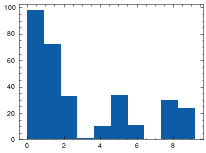

In [131]:
plt.hist(losses)


In [87]:
np.mean(losses)


2.9358926045066087

In [ ]:
composition_mismatches


In [155]:
completions_0 = query_gpt3(
    "ada:ft-epfl-2022-06-25-15-34-15", df_test, max_tokens=200, temperature=0
)


In [272]:
completions_05 = query_gpt3(
    "ada:ft-epfl-2022-06-25-15-34-15", df_test, max_tokens=200, temperature=0.5
)


In [275]:
completions_10 = query_gpt3(
    "ada:ft-epfl-2022-06-25-15-34-15", df_test, max_tokens=200, temperature=1.0
)


In [156]:
completion_texts_0 = [completion["choices"][0]["text"] for completion in completions_0]


In [273]:
completion_texts_05 = [completion["choices"][0]["text"] for completion in completions_05]


In [276]:
completion_texts_10 = [completion["choices"][0]["text"] for completion in completions_10]


In [186]:
train_sequences = [string2performance(seq)["monomer_squence"] for seq in df_train["completion"]]


In [261]:
np.random.shuffle(train_sequences)


In [385]:
get_distance(completion_data["prediction"][0], 2, bins)

2.601691648679342

In [278]:
def get_metrics(completion_texts):
    losses = []
    composition_mismatches = []

    for i, row in tqdm(df_test.iterrows(), total=len(completion_texts)):
        if i < len(completion_texts):
            try:
                composition, bin = get_prompt_data(row["prompt"])
                completion_data = string2performance(completion_texts[i])
                loss = get_distance(completion_data["prediction"][0], bin, bins)
                losses.append(loss)

                mm = composition_mismatch(composition, completion_data["composition"])
                distances = string_distances(
                    train_sequences[:2000], completion_data["monomer_squence"]
                )
                mm.update(completion_data)
                mm.update(distances)
                mm.update({"loss": loss})
                composition_mismatches.append(mm)
            except Exception as e:
                print(e)
    return losses, pd.DataFrame(composition_mismatches)


In [263]:
losses_test, composition_mismatches_test = get_metrics(df_test["completion"])


100%|██████████| 313/313 [23:52<00:00,  4.58s/it]


In [264]:
losses_0, composition_mismatches_0 = get_metrics(completion_texts_0)


100%|██████████| 313/313 [24:30<00:00,  4.70s/it]


In [274]:
losses_05, composition_mismatches_05 = get_metrics(completion_texts_05)


100%|██████████| 313/313 [1:39:28<00:00, 19.07s/it]   


In [279]:
losses_10, composition_mismatches_10 = get_metrics(completion_texts_10)


 26%|██▌       | 82/313 [08:07<21:41,  5.63s/it]

'o'


100%|██████████| 313/313 [31:20<00:00,  6.01s/it]


In [368]:
df_loss = pd.DataFrame(
    {
        "loss": losses_test + losses_0 + losses_05 + losses_10,
        "name": ["test"] * len(losses_test)
        + [0] * len(losses_0)
        + [0.5] * len(losses_05)
        + [1.0] * len(losses_10),
    }
)


df_levelstein = pd.DataFrame(
    {
        "levenein": composition_mismatches_test["NormalizedLevenshtein_min"].to_list()
        + composition_mismatches_0["NormalizedLevenshtein_min"].to_list()
        + composition_mismatches_05["NormalizedLevenshtein_min"].to_list()
        + composition_mismatches_10["NormalizedLevenshtein_min"].to_list(),
        "name": ["test"] * len(composition_mismatches_test["NormalizedLevenshtein_min"])
        + [0] * len(composition_mismatches_0["NormalizedLevenshtein_min"])
        + [0.5] * len(composition_mismatches_05["NormalizedLevenshtein_min"])
        + [1.0] * len(composition_mismatches_10["NormalizedLevenshtein_min"]),
    }
)

df_composition = pd.DataFrame(
    {
        "composiion": composition_mismatches_test["mean"].to_list()
        + composition_mismatches_0["mean"].to_list()
        + composition_mismatches_05["mean"].to_list()
        + composition_mismatches_10["mean"].to_list(),
        "name": ["test"] * len(composition_mismatches_test["mean"])
        + [0] * len(composition_mismatches_0["mean"])
        + [0.5] * len(composition_mismatches_05["mean"])
        + [1.0] * len(composition_mismatches_10["mean"]),
    }
)

df_substring = pd.DataFrame(
    {
        "substring": composition_mismatches_test["LongestCommonSubsequence_max"].to_list()
        + composition_mismatches_0["LongestCommonSubsequence_max"].to_list()
        + composition_mismatches_05["LongestCommonSubsequence_max"].to_list()
        + composition_mismatches_10["LongestCommonSubsequence_max"].to_list(),
        "name": ["test"] * len(composition_mismatches_test["LongestCommonSubsequence_max"])
        + [0] * len(composition_mismatches_0["LongestCommonSubsequence_max"])
        + [0.5] * len(composition_mismatches_05["LongestCommonSubsequence_max"])
        + [1.0] * len(composition_mismatches_10["LongestCommonSubsequence_max"]),
    }
)


3.3

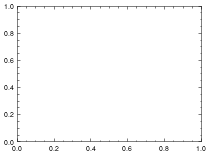

In [358]:
fig, ax = plt.subplots()
fig.get_figwidth()

In [386]:
np.mean(losses_test)

2.9358926045066087

In [399]:
np.mean(losses_0)

2.8612383391729392

In [400]:
np.mean(losses_05)

2.957585139492623

In [401]:
np.mean(losses_10)

2.9634087864690914

/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit 

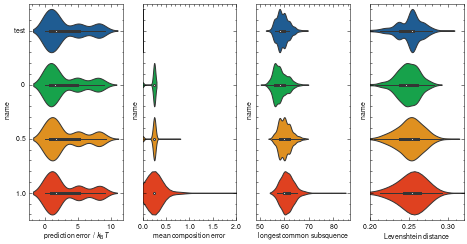

In [398]:
fig, ax = plt.subplots(1, 4, figsize=(6.6, 3.5), sharey='all')

sns.violinplot(df_loss["loss"], df_loss["name"], ax=ax[0], scale='width')

sns.violinplot(df_composition["composiion"], df_composition["name"], ax=ax[1] , scale='width')
ax[1].set_xlim(0,2)
sns.violinplot(df_substring["substring"], df_substring["name"], ax=ax[2], scale='width')

sns.violinplot(df_levelstein["levenein"], df_levelstein["name"], ax=ax[3], scale='width')
ax[3].set_xlim(0.2, 0.32)


ax[0].set_xlabel('prediction error / $k_\mathrm{B}T$')
ax[1].set_xlabel('mean composition error')
ax[2].set_xlabel('longest common subsquence')
ax[3].set_xlabel('Levenshtein distance')

fig.tight_layout()

fig.savefig('polymer_inverse_design.pdf', bbox_inches='tight')

<AxesSubplot:>

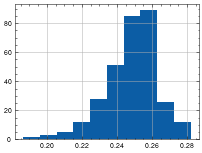

In [345]:
composition_mismatches_0["NormalizedLevenshtein_min"].hist()


<AxesSubplot:>

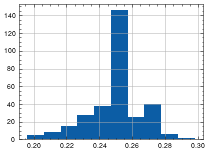

In [346]:
composition_mismatches_test["NormalizedLevenshtein_min"].hist()


<AxesSubplot:>

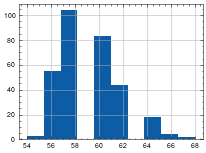

In [347]:
composition_mismatches_test["LongestCommonSubsequence_max"].hist()


<AxesSubplot:>

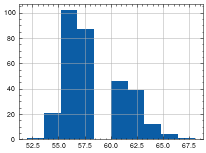

In [348]:
composition_mismatches_0["LongestCommonSubsequence_max"].hist()


In [349]:
composition_mismatches_0["NormalizedLevenshtein_min"].min()


0.1864406779661017

In [350]:
composition_mismatches_test["NormalizedLevenshtein_min"].min()


0.19607843137254902

In [351]:
composition_mismatches_test["NormalizedLevenshtein_mean"].min()


0.370651613653096

In [352]:
composition_mismatches_0["NormalizedLevenshtein_mean"].min()


0.3639052357650537

In [367]:
composition_mismatches_0

,distances,min,max,mean,expected_len,found_len,monomer_squence,composition,smiles,prediction,...,Levenshtein_std,NormalizedLevenshtein_min,NormalizedLevenshtein_max,NormalizedLevenshtein_mean,NormalizedLevenshtein_std,LongestCommonSubsequence_min,LongestCommonSubsequence_max,LongestCommonSubsequence_mean,LongestCommonSubsequence_std,loss
0,"[0, 1, 0, 0]",0,1,0.25,40,41,B-R-B-W-B-R-W-B-R-W-A-B-W-R-A-B-W-R-A-B-W-R-A-...,"{'B': 13, 'R': 10, 'W': 10, 'A': 8}",[Tr][R][Tr][W][Tr][R][W][Tr][R][W][Ta][Tr][W][...,[-8.214346],...,4.830734,0.259259,0.654321,0.393965,0.060349,30,56,43.540,3.528796,1.876131
1,"[0, 1, 0, 0]",0,1,0.25,36,37,A-A-A-A-B-A-B-W-B-A-B-W-A-B-W-R-A-B-W-R-A-B-W-...,"{'A': 12, 'B': 11, 'W': 8, 'R': 6}",[Ta][Ta][Ta][Ta][Tr][Ta][Tr][W][Tr][Ta][Tr][W]...,[-8.772864],...,3.878215,0.253333,0.643836,0.379619,0.052744,28,60,41.420,4.046183,1.317613
2,"[0, 0, 1, 0]",0,1,0.25,30,31,R-R-R-R-R-R-A-R-W-B-A-R-W-B-A-R-W-B-A-R-W-B-A-...,"{'R': 13, 'A': 6, 'W': 6, 'B': 6}",[R][R][R][R][R][R][Ta][R][W][Tr][Ta][R][W][Tr]...,[-9.036897],...,4.505324,0.253968,0.573770,0.374857,0.040442,24,58,38.450,5.097597,8.108926
3,"[0, 1, 0, 0]",0,1,0.25,38,39,W-B-W-B-W-B-W-R-B-W-R-B-W-A-W-B-R-B-W-A-R-B-W-...,"{'W': 12, 'B': 13, 'R': 8, 'A': 6}",[W][Tr][W][Tr][W][Tr][W][R][Tr][W][R][Tr][W][T...,[-8.214346],...,4.347494,0.259740,0.636364,0.386380,0.057372,28,58,42.444,3.803007,1.651542
4,"[0, 0, 1, 0]",0,1,0.25,34,35,W-B-B-W-R-W-B-W-R-B-W-A-R-B-W-A-R-B-W-R-A-B-W-...,"{'W': 10, 'B': 10, 'R': 9, 'A': 6}",[W][Tr][Tr][W][R][W][Tr][W][R][Tr][W][Ta][R][T...,[-7.9429283],...,3.447675,0.260870,0.594203,0.367821,0.044923,24,56,38.723,4.020855,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,"[0, 0, 1, 0]",0,1,0.25,36,37,W-R-A-A-W-R-A-W-R-A-W-R-A-W-R-A-R-W-B-A-R-W-B-...,"{'W': 10, 'R': 11, 'A': 10, 'B': 6}",[W][R][Ta][Ta][W][R][Ta][W][R][Ta][W][R][Ta][W...,[-8.524666],...,3.780072,0.246575,0.616438,0.375808,0.051580,28,56,40.349,3.849182,8.621157
309,"[0, 0, 1, 0]",0,1,0.25,38,39,W-R-W-R-R-B-W-R-B-W-R-W-B-R-W-B-R-W-B-R-W-B-R-...,"{'W': 12, 'R': 13, 'B': 10, 'A': 4}",[W][R][W][R][R][Tr][W][R][Tr][W][R][W][Tr][R][...,[-8.994056],...,4.444665,0.246753,0.649351,0.389130,0.058847,30,56,42.956,3.886652,1.096421
310,"[0, 1, 0, 0]",0,1,0.25,40,41,A-A-A-B-A-B-R-R-B-R-B-A-B-R-A-B-A-R-W-B-A-R-W-...,"{'A': 12, 'B': 13, 'R': 10, 'W': 6}",[Ta][Ta][Ta][Tr][Ta][Tr][R][R][Tr][R][Tr][Ta][...,[-9.65991],...,4.979476,0.234568,0.654321,0.402607,0.062236,32,56,45.006,3.756589,7.485913
311,"[0, 0, 0, 0]",0,0,0.00,26,26,A-R-A-R-A-R-B-A-R-B-A-R-B-W-A-R-B-W-A-R-B-W-A-...,"{'A': 8, 'R': 8, 'B': 6, 'W': 4, '': 1}",[Ta][R][Ta][R][Ta][R][Tr][Ta][R][Tr][Ta][R][Tr...,[-7.3276353],...,6.587280,0.250000,0.538462,0.391451,0.045666,21,57,35.951,6.153178,6.290515
